# Machine Learning using PySpark

## Clustering

## K-means

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("PySpark k-means") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
spark

In [52]:
## create data
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
features = iris.data
target = iris.target.reshape(150,1)

data = np.hstack((features,target))
names  = iris.feature_names
names.append('species')
names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)',
 'species']

In [53]:
data = spark.createDataFrame(data.tolist(), names)
data.show(5)

+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2|    0.0|
|              4.9|             3.0|              1.4|             0.2|    0.0|
|              4.7|             3.2|              1.3|             0.2|    0.0|
|              4.6|             3.1|              1.5|             0.2|    0.0|
|              5.0|             3.6|              1.4|             0.2|    0.0|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows



In [54]:
data.printSchema()

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- species: double (nullable = true)



In [55]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|           species|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333334|3.0573333333333337|3.7580000000000005|1.1993333333333331|               1.0|
| stddev|0.8280661279778623|0.4358662849366982|1.7652982332594664|0.7622376689603466|0.8192319205190405|
|    min|               4.3|               2.0|               1.0|               0.1|               0.0|
|    max|               7.9|               4.4|               6.9|               2.5|               2.0|
+-------+------------------+------------------+------------------+------------------+------------------+



In [69]:
# convert the data to dense vector
from pyspark.ml.linalg import Vectors
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

In [70]:
transformed= transData(data)
transformed.show(5, False)

+-----------------+
|features         |
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
+-----------------+
only showing top 5 rows



In [73]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

df = featureIndexer.transform(transformed)
df.show(5)

+-----------------+-----------------+
|         features|  indexedFeatures|
+-----------------+-----------------+
|[5.1,3.5,1.4,0.2]|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|
+-----------------+-----------------+
only showing top 5 rows



In [74]:
## choose the best k
import numpy as np
from pyspark.ml.clustering import KMeans
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("indexedFeatures")\
            .setPredictionCol("cluster")

    model = kmeans.fit(transformed)
    cost[k] = model.computeCost(transformed)

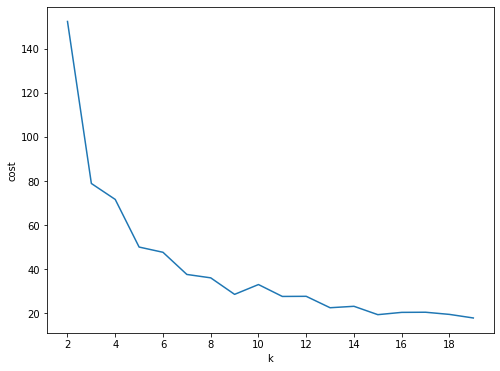

In [75]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [76]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans() \
          .setK(3) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed)

cluster = model.transform(transformed)

In [77]:
cluster.show()

+-----------------+-----------------+-------+
|         features|  indexedFeatures|cluster|
+-----------------+-----------------+-------+
|[5.1,3.5,1.4,0.2]|[5.1,3.5,1.4,0.2]|      2|
|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|      2|
|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|      2|
|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|      2|
|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|      2|
|[5.4,3.9,1.7,0.4]|[5.4,3.9,1.7,0.4]|      2|
|[4.6,3.4,1.4,0.3]|[4.6,3.4,1.4,0.3]|      2|
|[5.0,3.4,1.5,0.2]|[5.0,3.4,1.5,0.2]|      2|
|[4.4,2.9,1.4,0.2]|[4.4,2.9,1.4,0.2]|      2|
|[4.9,3.1,1.5,0.1]|[4.9,3.1,1.5,0.1]|      2|
|[5.4,3.7,1.5,0.2]|[5.4,3.7,1.5,0.2]|      2|
|[4.8,3.4,1.6,0.2]|[4.8,3.4,1.6,0.2]|      2|
|[4.8,3.0,1.4,0.1]|[4.8,3.0,1.4,0.1]|      2|
|[4.3,3.0,1.1,0.1]|[4.3,3.0,1.1,0.1]|      2|
|[5.8,4.0,1.2,0.2]|[5.8,4.0,1.2,0.2]|      2|
|[5.7,4.4,1.5,0.4]|[5.7,4.4,1.5,0.4]|      2|
|[5.4,3.9,1.3,0.4]|[5.4,3.9,1.3,0.4]|      2|
|[5.1,3.5,1.4,0.3]|[5.1,3.5,1.4,0.3]|      2|
|[5.7,3.8,1.7,0.3]|[5.7,3.8,1.7,0.

In [78]:
#PySpark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def optimal_k(df_in,index_col,k_min, k_max,num_runs):
    '''
    Determine optimal number of clusters by using Silhoutte Score Analysis.
    :param df_in: the input dataframe
    :param index_col: the name of the index column
    :param k_min: the train dataset
    :param k_min: the minmum number of the clusters
    :param k_max: the maxmum number of the clusters
    :param num_runs: the number of runs for each fixed clusters

    :return k: optimal number of the clusters
    :return silh_lst: Silhouette score
    :return r_table: the running results table

    :author: Wenqiang Feng
    :email:  von198@gmail.com
    '''

    start = time.time()
    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)
            r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('prediction').toPandas()

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        silh_array=np.asanyarray(silh_val)
        silh_lst.append(silh_array.mean())

    elapsed =  time.time() - start

    silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k', 'silhouette'])

    print('+------------------------------------------------------------+')
    print("|         The finding optimal k phase took %8.0f s.       |" %(elapsed))
    print('+------------------------------------------------------------+')


    return k_lst[np.argmax(silh_lst, axis=0)], silhouette , r_table

In [79]:
k, silh_lst, r_table = optimal_k(scaledData,index_col,k_min, k_max,num_runs)

NameError: name 'scaledData' is not defined